# Old notebook not setup for new configuration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from multiprocessing import Pool
from scipy.optimize import minimize
sys.path.append("..")  # Adds higher directory to python modules path.

from main import MeasurementControlEnvironment
from mcts.mcts import MCTS
from mcts.hash import hash_action, hash_state

In [3]:
# Create a TMC object
tmc = MeasurementControlEnvironment(one_iteration=True)

Running one iteration for profiling


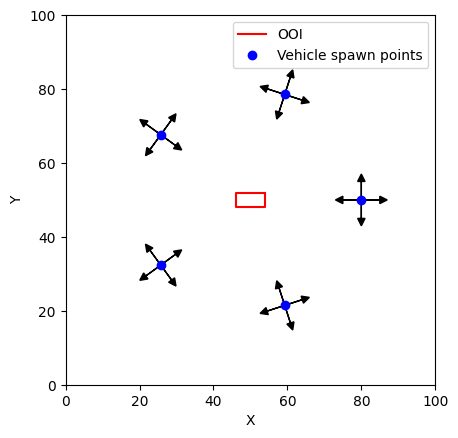

In [4]:
# Now lets plot the OOI and starting vehicle locations
ooi_corners = tmc.ooi.get_corners()
ooi_corners = np.concatenate([ooi_corners, ooi_corners[0].reshape((1,2))], axis=0).T  # Close the polygon

# Create plot set limits and labels
fig, ax = plt.subplots()
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal', 'box')

# Plot the OOI
plt.plot(ooi_corners[0], ooi_corners[1], 'r-', label='OOI')

# Creat a circle for the vehicle spawnpoints
center = np.array(tmc.ooi.position)
radius = 30
num_points = 5
angle_increment = 2*np.pi/num_points
circle_points = np.zeros((2, num_points)) 

def rotate(vec, angle, center):
    R = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return R @ (vec - center) + center

vec = center + np.array([radius, 0])
for i in range(num_points):
    circle_points[:,i] = rotate(vec, angle_increment*i, center)

# Plot the circle points
plt.plot(circle_points[0], circle_points[1], 'bo', label='Vehicle spawn points')

# Create four directions for each point, towards, away, left and right
car_starting_states = np.zeros((4*num_points, 3))

# Fill in the starting states
for i in range(num_points):
    # First for the four directions of the car at one point, fill in the x and y
    car_starting_states[4*i:4*i+4, 0:2] = circle_points[:,i]
    
    # Assuming the car starts facing the center of the circle,
    # Rotate the car to face the four directions and assign the angle
    for j, rot_angle in enumerate([0, np.pi/2, -np.pi/2, np.pi]):
        pt_to_center = center - circle_points[:,i]
        angle = np.arctan2(pt_to_center[1], pt_to_center[0]) + rot_angle
        car_starting_states[4*i+j, 2] = angle
    
# Plot the starting states arrows
for i in range(4*num_points):
    angle = car_starting_states[i, 2]
    x = car_starting_states[i, 0]
    y = car_starting_states[i, 1]
    dx = 5 * np.cos(angle)
    dy = 5 * np.sin(angle)
    plt.arrow(x, y, dx, dy, head_width=2, head_length=2, fc='k', ec='k')

plt.legend()

In [5]:
# Get the OOI starting state and covariance starting state
default_state = tmc.get_state()
mean_init = default_state[1]
cov_init = default_state[2]

# print("Starting state mean: ", mean_init)
# print("Starting state covariance: ", cov_init)

In [10]:
# Now that we have a list of starting states we can use them to calculate cost based on parameters
def get_mcts_cost(starting_car_state, exploration_factor=0., num_iterations=400,
                  eval_dist_scale=0., eval_bearing_scale=0.,
                  eval_ocl_dist_scale=0., eval_ocl_turn_scale=0.,
                  evaluation_multiplier=0.):
    
    # Load the parameters into the TMC object
    tmc.eval_dist_scale = eval_dist_scale
    tmc.eval_bearing_scale = eval_bearing_scale
    tmc.eval_ocl_dist_scale = eval_ocl_dist_scale
    tmc.eval_ocl_turn_scale = eval_ocl_turn_scale
    tmc.evaluation_multiplier = evaluation_multiplier
    
    # Format into a tuple as expected by MCTS
    starting_state = (starting_car_state, mean_init, cov_init, 0)
    
    # Create an MCTS object
    mcts = MCTS(initial_obs=starting_state, env=tmc, K=exploration_factor,
                            _hash_action=hash_action, _hash_state=hash_state,
                            expansion_branch_factor=tmc.expansion_branch_factor)
    
    # Run learning iterations to create tree
    mcts.learn(num_iterations)
    
    # Pick the best action and return the average reward
    best_action = mcts.best_action()
    best_node = mcts.root.children[best_action]
    
    return best_node.cumulative_reward / best_node.visits

In [17]:
# Now we can calculate the cost for all starting states
def explore_total_cost(exploration_factor=0.001):
    print("Exploration factor: ", exploration_factor)
    sums = [get_mcts_cost(starting_state, exploration_factor) for starting_state in car_starting_states]
    
    # Get total cost by negating the sum of the rewards
    total_cost = -np.sum(sums)
    print("Total cost: ", total_cost)
    
    return total_cost

result = minimize(explore_total_cost, 0.001, method='Nelder-Mead', bounds=[(0., 100)])
print(result)
print("Best exploration factor: ", result.x)

Exploration factor:  [0.001]
Total cost:  14.174557375780221
Exploration factor:  [0.00105]
Total cost:  14.160942104300426
Exploration factor:  [0.0011]
Total cost:  14.195667037422474
Exploration factor:  [0.001025]
Total cost:  14.174557375780221
Exploration factor:  [0.001025]
Total cost:  14.174557375780221
Exploration factor:  [0.001075]
Total cost:  14.195667037422474
Exploration factor:  [0.0010375]
Total cost:  14.174557375780221
Exploration factor:  [0.0010375]
Total cost:  14.174557375780221
Exploration factor:  [0.0010625]
Total cost:  14.160942104300426
Exploration factor:  [0.00105625]
Total cost:  14.160942104300426
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 14.160942104300426
             x: [ 1.050e-03]
           nit: 4
          nfev: 10
 final_simplex: (array([[ 1.050e-03],
                       [ 1.056e-03]]), array([ 1.416e+01,  1.416e+01]))
Best exploration factor:  [0.00105]


In [7]:
explore_total_cost(0)

Exploration factor:  0
Total cost:  12.38163112361997


12.38163112361997

In [15]:
def eval_total_cost(evaluation_multiplier):
    print("Evaluation multiplier: ", evaluation_multiplier)
    sums = [get_mcts_cost(starting_state, 0.001, evaluation_multiplier=evaluation_multiplier) for starting_state in car_starting_states]
    
    total_cost = -np.sum(sums)
    print("Total cost: ", total_cost)
    return total_cost

result = minimize(eval_total_cost, 0.1, method='Nelder-Mead', bounds=[(0., 1.)])

print(result)
print("Best evaluation multiplier: ", result.x)

Evaluation multiplier:  [0.1]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.105]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.095]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.1025]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.1025]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.0975]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.10125]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.10125]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.09875]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.100625]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.100625]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.099375]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.1003125]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.1003125]
Total cost:  14.174557375780221
Evaluation multiplier:  [0.0996875]
Total cost:  14.174557375780221
Evaluation m

In [16]:
eval_total_cost(0)

Evaluation multiplier:  0
Total cost:  14.174557375780221


14.174557375780221